In [1]:
from dataset import load_abalone
X, y = load_abalone()
print(X.shape)
print(y.shape)

(4177, 8)
(4177,)


In [2]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scale y
y_train = y_train
y_test = y_test

In [3]:
from Mondrian_forest import evaluate_all_lifetimes

In [4]:
M = 10                      # number of Mondrian trees to use
delta = 0 
lifetime_max = 10

In [5]:
results = []
results.append(
    evaluate_all_lifetimes(X_train, 
                           y_train, 
                           X_test, y_test, M, lifetime_max, delta))

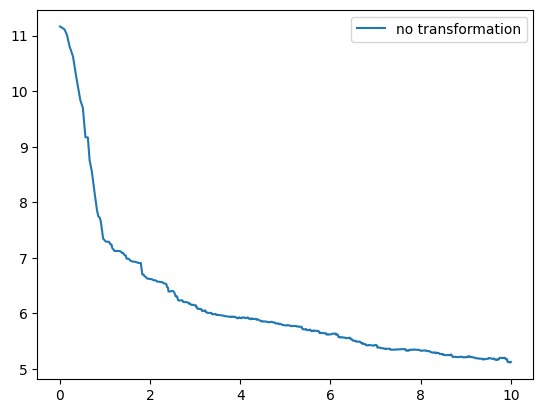

In [6]:
import matplotlib.pyplot as plt
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.legend()

In [7]:
from Mondrian_forest import train
from estimate_H import estimate_H_finite_diff
from Mondrian_forest import transform_data, two_one_norm
history, w_trees = train(
            X_train, y_train, M, lifetime_max, delta
        )
H_1 = estimate_H_finite_diff(X_train, y_train, M, history, w_trees, step=0.1)
X_train_transformed, X_test_transformed = transform_data(H_1/two_one_norm(H_1), X_train, X_test)

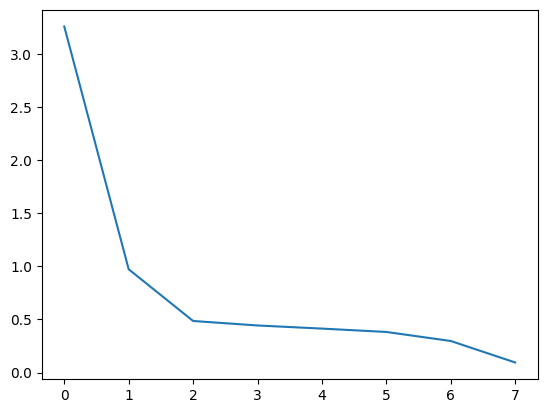

In [8]:
import numpy as np
eigvals = np.linalg.eig(H_1/two_one_norm(H_1))[0]
# sort eigenvalues
eigvals = np.sort(eigvals)[::-1]
# plot eigenvalues
plt.plot(eigvals)

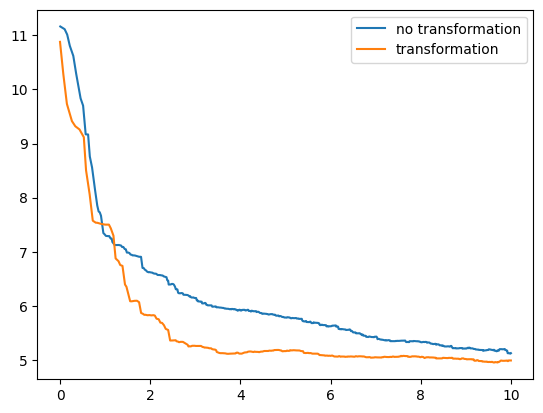

In [9]:
results.append(
    evaluate_all_lifetimes(X_train_transformed, 
                           y_train, 
                           X_test_transformed, y_test, M, lifetime_max, delta))
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.legend()

In [10]:
import numpy as np
history, w_trees = train(
            X_train_transformed, y_train, M, lifetime_max, delta
        )
H_2 = estimate_H_finite_diff(X_train_transformed, y_train, M, history, w_trees, step=0.1)
X_train_transformed, X_test_transformed = transform_data(H_2 * two_one_norm(H_1) / two_one_norm(np.matmul(H_2, H_1)), X_train_transformed, X_test_transformed)


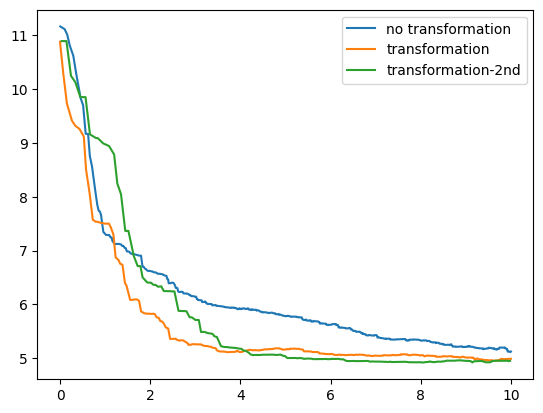

In [11]:
results.append(
    evaluate_all_lifetimes(X_train_transformed, 
                           y_train, 
                           X_test_transformed, y_test, M, lifetime_max, delta))
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transformation-2nd')
plt.legend()

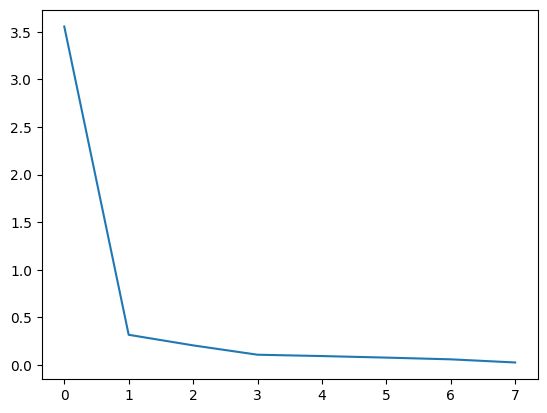

In [12]:
eigvals = np.linalg.eig(np.matmul(H_2, H_1)/two_one_norm(np.matmul(H_2, H_1)))[0]
# sort eigenvalues
eigvals = np.sort(eigvals)[::-1]
# plot eigenvalues
plt.plot(eigvals)

In [13]:
# fit random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mse

5.150927916587653

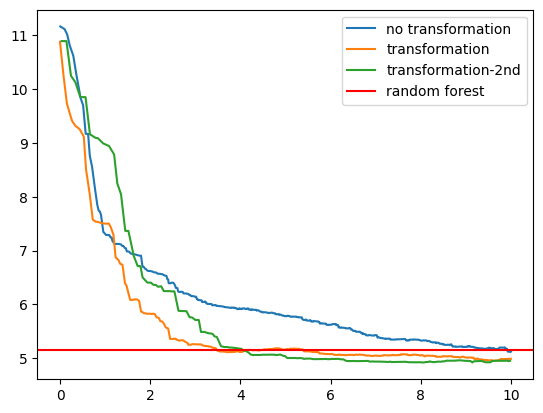

In [14]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transformation-2nd')
# add a horizontal line for the random forest
plt.axhline(y=rf_mse, color='r', linestyle='-', label = 'random forest')
plt.legend()

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=5)
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict(X_test_transformed)
err = mean_squared_error(y_test, y_pred)
err

4.874741077923715

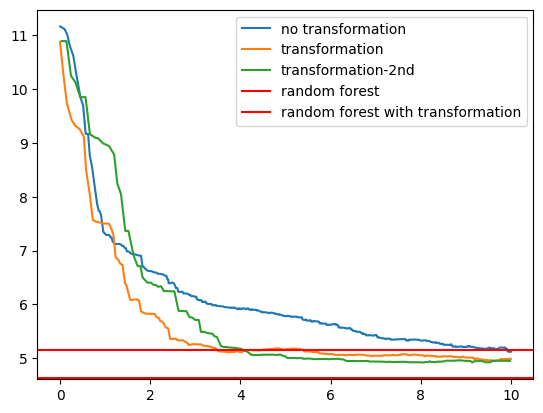

In [19]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transformation-2nd')
# add a horizontal line for the random forest
plt.axhline(y=rf_mse, color='r', linestyle='-', label = 'random forest')
plt.axhline(y=err, color='r', linestyle='-', label = 'random forest with transformation')
plt.legend()

In [16]:
from sklearn.pipeline import Pipeline
from others.sir import SlicedInverseRegression
forest = Pipeline([
    ('sir', SlicedInverseRegression(n_directions=None)),
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, max_depth=5))
    ]).fit(X_train, y_train)
y_pred = forest.predict(X_test)
err = mean_squared_error(y_test, y_pred)
err

4.491607904008983

In [17]:
from others.save import SlicedAverageVarianceEstimation
forest = Pipeline([
('save', SlicedAverageVarianceEstimation(n_directions=None)),
('rf', RandomForestRegressor(n_estimators=10,random_state=42, max_depth=5))
]).fit(X_train, y_train)
y_pred = forest.predict(X_test)
err = mean_squared_error(y_test, y_pred)
err

4.633238630740474